In [1]:
%pip install matplotlib sklearn pandas scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torchvision as thv
import torch 
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Compose, RandomCrop, Resize, Normalize
from torch.optim.lr_scheduler import ExponentialLR
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from skimage import io, color
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
fitzDF = pd.read_csv('./fitzpatrick17k.csv') 
fitzDF.head(5)

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [5]:
#check how many unique labels there are
len(fitzDF['label'].unique())

#check how many rows fitzDF has fitzpatrick with value 6 and a three_partition_label with value of 'malignant'
fitz6 = len(fitzDF[(fitzDF['fitzpatrick'] == 6) & (fitzDF['three_partition_label'] == 'malignant')])
fitz5 = len(fitzDF[(fitzDF['fitzpatrick'] == 5) & (fitzDF['three_partition_label'] == 'malignant')])
fitz4 = len(fitzDF[(fitzDF['fitzpatrick'] == 4) & (fitzDF['three_partition_label'] == 'malignant')])
fitz3 = len(fitzDF[(fitzDF['fitzpatrick'] == 3) & (fitzDF['three_partition_label'] == 'malignant')])
fitz2 = len(fitzDF[(fitzDF['fitzpatrick'] == 2) & (fitzDF['three_partition_label'] == 'malignant')])
fitz1 = len(fitzDF[(fitzDF['fitzpatrick'] == 1) & (fitzDF['three_partition_label'] == 'malignant')])

data = {'fitzpatrick': [6, 5, 4, 3, 2, 1],
        'malignant': [fitz6, fitz5, fitz4, fitz3, fitz2, fitz1]}

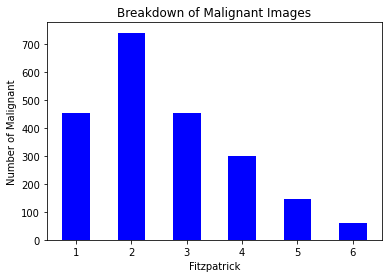

In [6]:
plt.bar(data['fitzpatrick'], data['malignant'], width=0.5, color='b')
plt.xlabel('Fitzpatrick')
plt.ylabel('Number of Malignant')
plt.title('Breakdown of Malignant Images')
plt.show()

In [7]:
malignant_fitzDF = fitzDF[fitzDF['three_partition_label'] == 'malignant']
malignantCount = len(malignant_fitzDF)
benign = fitzDF[fitzDF['three_partition_label'] == 'benign']
benignCount = len(benign)
neoplastic = fitzDF[fitzDF['three_partition_label'] == 'non-neoplastic']
neoplasticCount = len(neoplastic)

In [8]:
indices = np.arange(len(fitzDF))

In [9]:
transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
            ])

imgListOfTensors = []

for md5hash in fitzDF.md5hash:
    if os.path.exists('./finalfitz17k/' + md5hash + '.jpg'):

        img = io.imread('./finalfitz17k/' + md5hash + '.jpg')
        if(len(img.shape) < 3):
            img = color.gray2rgb(img)
        image = transform(img)
        imgListOfTensors += [image]
    else:
        fitzDF = fitzDF.drop(md5hash)
imgListOfTensors = torch.stack(imgListOfTensors)
print(imgListOfTensors.shape)

torch.Size([16577, 3, 224, 224])


In [10]:
diagnosis = fitzDF.three_partition_label.values

tempList = []

for i in range(len(diagnosis)):
    if diagnosis[i] == 'non-neoplastic':
        temp = [1, 0, 0]
    elif diagnosis[i] == 'benign':
        temp = [0, 1, 0]
    elif diagnosis[i] == 'malignant':
        temp = [0, 0, 1]
    tempList += [temp]
diagnosisNP = np.array(tempList)

In [11]:
xDataNP = imgListOfTensors.numpy()
yDataNP = diagnosisNP
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(xDataNP, yDataNP, indices, test_size=0.2, random_state=42)

train_data = TensorDataset(torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device))
test_data = TensorDataset(torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device))

In [12]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    ).to(device)

In [13]:
EPOCHS = 50
batch_size = 128
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

# Training 

In [14]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [15]:
def Train(model, loader, optimizer, criterion):
  epoch_loss = []
  epoch_acc = 0

  model.train()
  for data, labels in loader:
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = criterion(output, labels.float())
    epoch_loss.append(loss.item())
    
    preds = output.argmax(dim=1)
    labels = labels.argmax(dim=1)
    epoch_acc += (preds == labels).cpu().sum()
    
    loss.backward()
    optimizer.step()
    
  return np.mean(epoch_loss), epoch_acc / len(loader.dataset)

In [16]:
def evaluate(model, loader, criterion, test=False):
  epoch_loss = []
  epoch_acc = 0
  predicted, expected = [], []

  model.eval()
  with torch.no_grad():
    for text, labels in loader:

      output = model(text)

      loss = criterion(output, labels.float())
      epoch_loss.append(loss.item())
    
      preds = output.argmax(dim=1)
      labels = labels.argmax(dim=1)
      epoch_acc += (preds == labels).cpu().sum()

      predicted.append(preds)
      expected.append(labels)

  if test:
    expected = np.array(torch.cat(expected).cpu(), dtype=float)
    predicted = np.array(torch.cat(predicted).cpu(), dtype=float)
    precision, recall, fscore, _ = precision_recall_fscore_support(expected, predicted, average='macro')
    accuracy = accuracy_score(expected, predicted)
    print('Scores:')
    print(f'Precision: {precision}, Recall: {recall}, Fscore: {fscore}, Accuracy: {accuracy}')

  return predicted, expected

In [17]:
train_loss = []
train_acc = []

for epoch in range(EPOCHS):
  trainEpochLoss, trainEpochAcc = Train(model, train_loader, optimizer, criterion)
  train_loss.append(trainEpochLoss)
  train_acc.append(trainEpochAcc)

  print(f'Epoch: {epoch} Train Loss: {trainEpochLoss} Train Acc: {trainEpochAcc}')

Epoch: 0 Train Loss: 0.7249747856149396 Train Acc: 0.7290551066398621
Epoch: 1 Train Loss: 0.667174017545089 Train Acc: 0.7421008944511414
Epoch: 2 Train Loss: 0.6528518194133796 Train Acc: 0.7491893768310547
Epoch: 3 Train Loss: 0.6382698486152204 Train Acc: 0.7528843879699707
Epoch: 4 Train Loss: 0.6383844379661152 Train Acc: 0.7512254118919373
Epoch: 5 Train Loss: 0.6270807538796397 Train Acc: 0.7583138346672058
Epoch: 6 Train Loss: 0.6204976077797344 Train Acc: 0.7605761289596558
Epoch: 7 Train Loss: 0.6233662960020084 Train Acc: 0.7589925527572632
Epoch: 8 Train Loss: 0.6153372529062252 Train Acc: 0.759520411491394
Epoch: 9 Train Loss: 0.6111378880959113 Train Acc: 0.7596712112426758
Epoch: 10 Train Loss: 0.5980531338927815 Train Acc: 0.7671366930007935
Epoch: 11 Train Loss: 0.5944313817811244 Train Acc: 0.7683432698249817
Epoch: 12 Train Loss: 0.5924207527660629 Train Acc: 0.7662318348884583
Epoch: 13 Train Loss: 0.5887112388911756 Train Acc: 0.7666088342666626
Epoch: 14 Train Lo

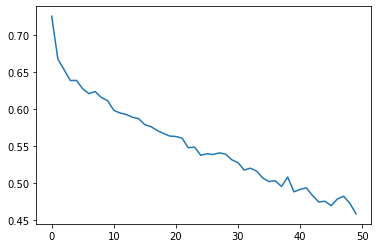

In [18]:
plt.plot(train_loss, label='Train Loss')
plt.show()

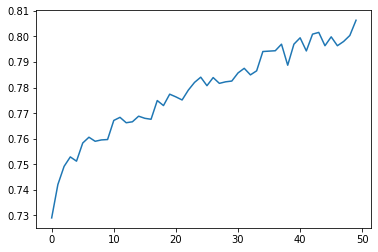

In [19]:
plt.plot(train_acc, label='Train Acc')
plt.show()

In [20]:
torch.cuda.empty_cache()

In [21]:
predicted, expected = evaluate(model, test_loader, criterion, test=True)

Scores:
Precision: 0.6643178886811215, Recall: 0.54249873903177, Fscore: 0.5728683654677554, Accuracy: 0.7871875


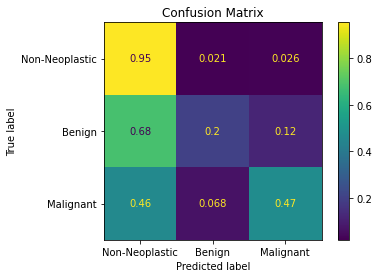

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(expected, predicted, labels=[0, 1, 2], normalize='true')
displayMatrix = ConfusionMatrixDisplay(matrix, display_labels=['Non-Neoplastic', 'Benign', 'Malignant'])
displayMatrix.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()


In [23]:
type6_df = []
for index, indice in enumerate(test_indices):
    if(predicted[index] == 2 and fitzDF['Unnamed' == indice].fitzpatrick == 6):
        type6_df += [fitzDF.iloc[indice]]


KeyError: False